## About the data

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')


## Data loading and exploring 

In [2]:
lung_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
lungs = os.listdir(lung_dir)
lungs

['lung_aca', 'lung_scc', 'lung_n']

In [3]:
lungs

['lung_aca', 'lung_scc', 'lung_n']

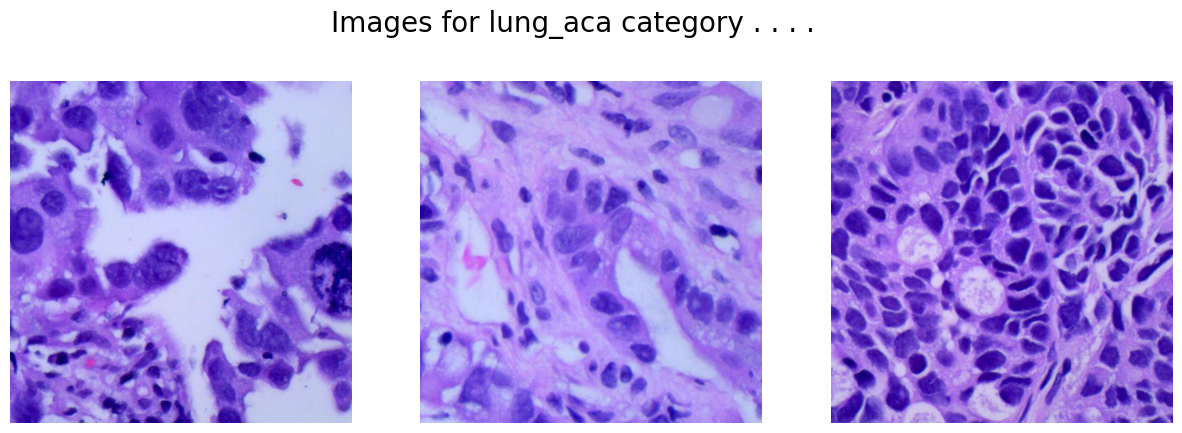

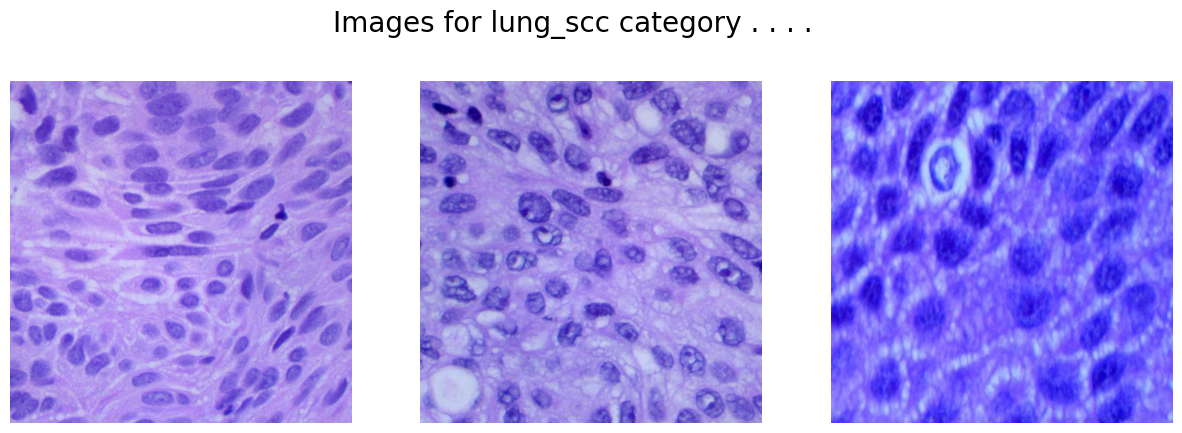

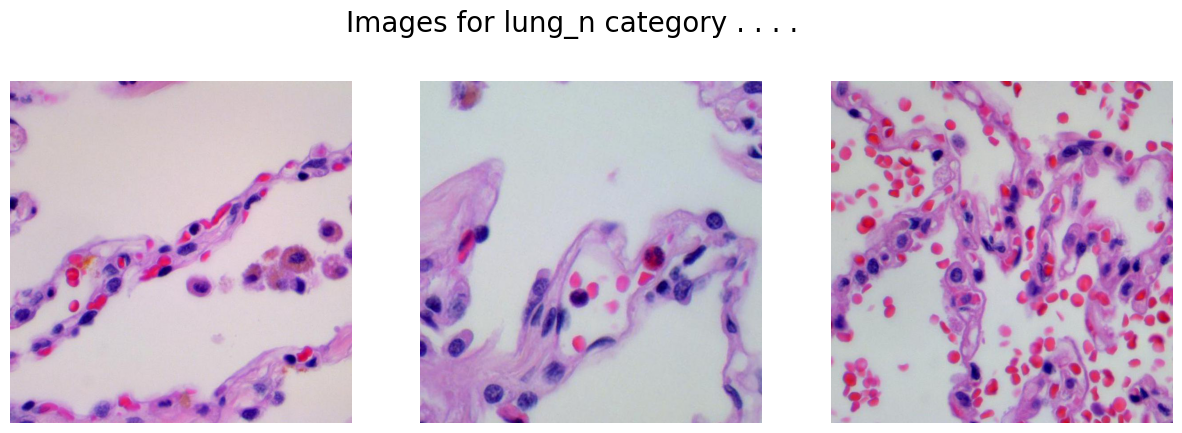

In [4]:

path= "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
for cat in lungs:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [5]:
IMG_SIZE = 180
SPLIT = 0.1
EPOCHS = 15
BATCH_SIZE = 64


In [6]:

X = []
Y = []
 
for i, cat in enumerate(lungs):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

# train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                          rotation_range = 20 ,
#                                                          horizontal_flip = True ,
#                                                          validation_split = 0.2
#                                                          )
# valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
# train_data = train_gen.flow_from_directory(lung_dir, subset='training', target_size=(IMG_SIZE,IMG_SIZE), batch_size=64, color_mode='rgb', 
#                                             class_mode='categorical', shuffle=True)

# val_data = valid_gen.flow_from_directory(lung_dir, subset='validation', target_size=(IMG_SIZE,IMG_SIZE), batch_size=64, color_mode='rgb', 
#                                             class_mode='categorical', shuffle=False)

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)
# import numpy
# unique, counts = numpy.unique(val_data.classes, return_counts=True)

# dict(zip(unique, counts))

(13500, 180, 180, 3) (1500, 180, 180, 3)


In [8]:
# model = keras.models.Sequential([
#     layers.Conv2D(filters=32,
#                   kernel_size=(5, 5),
#                   activation='relu',
#                   input_shape=(IMG_SIZE,
#                                IMG_SIZE,
#                                3),
#                   padding='same'),
#     layers.Dropout(0.1),
#     layers.MaxPooling2D(2, 2),
 
#     layers.Conv2D(filters=64,
#                   kernel_size=(3, 3),
#                   activation='relu',
#                   padding='same'),
#     layers.Dropout(0.15),
#     layers.MaxPooling2D(2, 2),
 
#     layers.Conv2D(filters=128,
#                   kernel_size=(3, 3),
#                   activation='relu',
#                   padding='same'),
#     layers.Dropout(0.2),
#     layers.MaxPooling2D(2, 2),
 
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dense(3, activation='softmax')
# ])

# model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))

model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(128, 3, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                    

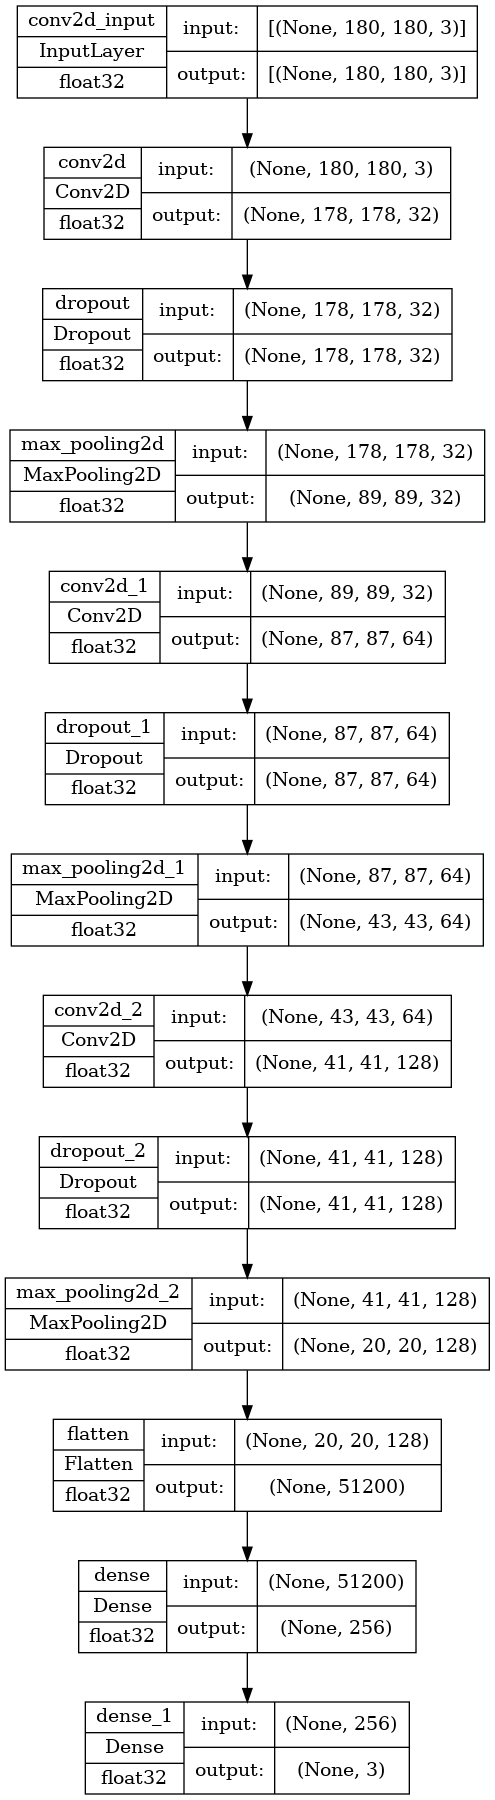

In [9]:

keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True
)

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.97:
            print('\n Validation accuracy has reached upto \
                      97% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

# history = model.fit(train_data,
#           validation_data=val_data,
#           epochs = 10)
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/15
211/211 [==============================] - 24s 115ms/step - loss: 1.0966 - accuracy: 0.3286 - val_loss: 1.0987 - val_accuracy: 0.3253 - lr: 5.0000e-04
Epoch 2/15
211/211 [==============================] - 24s 113ms/step - loss: 1.0980 - accuracy: 0.3324 - val_loss: 1.0966 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 3/15
211/211 [==============================] - 24s 113ms/step - loss: 0.9137 - accuracy: 0.5908 - val_loss: 0.7908 - val_accuracy: 0.6393 - lr: 5.0000e-04
Epoch 4/15
211/211 [==============================] - 24s 112ms/step - loss: 0.6239 - accuracy: 0.7247 - val_loss: 0.5768 - val_accuracy: 0.6933 - lr: 5.0000e-04
Epoch 5/15
211/211 [==============================] - 24s 112ms/step - loss: 0.5126 - accuracy: 0.7633 - val_loss: 0.4834 - val_accuracy: 0.7620 - lr: 5.0000e-04
Epoch 6/15
211/211 [==============================] - 24s 112ms/step - loss: 0.9101 - accuracy: 0.6407 - val_loss: 0.5844 - val_accuracy: 0.7113 - lr: 5.0000e-04
Epoch 7/15
211/211 [========

In [14]:
model.save('lung_cancer_detection.h5')

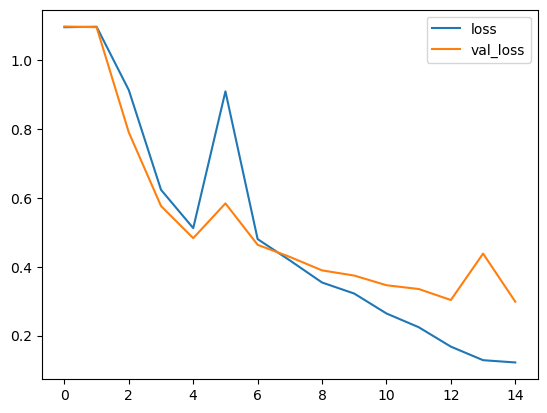

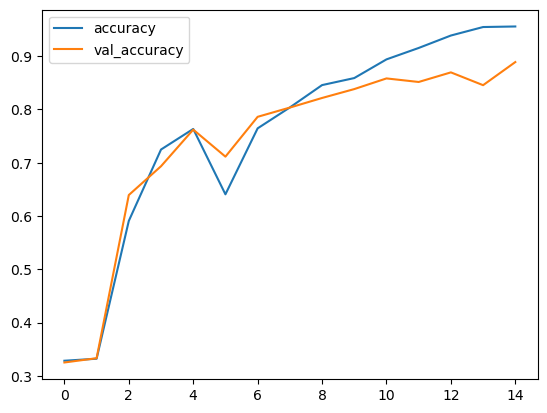

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [16]:
import os
os.chdir(r'/kaggle/working')
loaded_model = keras.models.load_model('lung_cancer_detection.h5')


In [17]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

47/47 [==============================] - 1s 9ms/step


In [19]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[408,  93,   5],
       [ 58, 428,   1],
       [  5,   5, 497]])

In [20]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=lungs))

              precision    recall  f1-score   support

    lung_aca       0.87      0.81      0.84       506
    lung_scc       0.81      0.88      0.85       487
      lung_n       0.99      0.98      0.98       507

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



In [38]:
path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg'

In [39]:
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
loaded_model = keras.models.load_model('lung_cancer_detection.h5')
# img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
# plt.show(img)
# img = img_to_array(img)
# img = np.expand_dims(img, axis=0)
# prediction = loaded_model.predict(img, batch_size=16)
x = []
img = cv2.imread(path)
x.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
x = np.asarray(x)
k = loaded_model.predict(x)
k = np.argmax(k,axis=1)
print(k)

1/1 [==============================] - 0s 120ms/step
[1]


In [42]:
import os
os.chdir(r'/kaggle/working')
!zip -r model.zip 'lung_cancer_detection.h5'
from IPython.display import FileLink
FileLink(r'model.zip')

  adding: lung_cancer_detection.h5 (deflated 44%)


/kaggle/working/model.zip